In [6]:
#|default_exp flattening.mioflow_quicktrain
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quicktrain for MIOFlow Standard

Regular MIOFlow hides its training behind a mess of functions and variables. Here, we adapt them into an easy-to-call class with an sklearn style fit-transform function. 

# Implementation

In [57]:
#|export
from fastcore.all import *
import time
from diffusion_curvature.flattening.mioflow import *
from diffusion_curvature.flattening.radial_ae import radially_flatten_with_ae
import shutil
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, mimwrite
from IPython.display import Image
import os
import torch
from heatgeo.embedding import HeatGeo
import pandas as pd
import base64
from IPython import display

class MIOFlowStandard():
    def __init__(
        self,
        embedding_dimension = 2, # dimension in which to embed the data. Should be the manifold's intrinsic dimension.
        use_cuda = torch.cuda.is_available(),
        autoencoder_type = "GAE",
        n_epochs_ode = 100,
        uniformity_loss = 'MMD',
        lr = 1e-5,
        
    ):
        store_attr()
        # These determine the logic flow for training: 
        #   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
        #   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
        #   use_emb=False use_gae=False Is not using the GAE.
        #   use_emb=True use_gae=True, is redundant and should raise an error. 
        self.use_emb = False
        self.use_gae = True
        self.need_to_train_gae = (self.use_emb or self.use_gae) and self.use_emb != self.use_gae
        # If the reconstruction loss needs to be computed.
        self.recon = self.use_gae and not self.use_emb 

    def setup_data(
        self,
        X, # np.array of shape (n_samples, n_features)
        D = None, # Optional distance matrix, np.array of shape (n_samples, n_samples). If not provided, computes with HeatGeo
        central_idx = 0, # Index of the central point in the dataset. If not provided, uses the first point.
    ):
        data = {'samples': [0] * len(X)} # all at time 0
        for i in range(X.shape[1]):
            data[f'd{i+1}'] = X[:, i]

        if D is None:
            emb_op = HeatGeo(knn=5)
            emb = emb_op.fit_transform(X)
            D = emb_op.dist
        
        # Create the dataframe
        df = pd.DataFrame(data)
        df['radial_dists'] = D[central_idx]
        self.model_features = len(df.columns) - 2
        self.groups = sorted(df.samples.unique())
        self.df = df
        return df

    def train_autoencoder(self,df):
        self.model_features = len(df.columns) - 2
        self.groups = sorted(df.samples.unique())
        use_cuda = self.use_cuda
        # This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
        hold_one_out = False
        # It can be a group number or 'random', works in tandem with hold_one_out
        hold_out = 3
        # The dimensions in the input space, it is columns - 2 because we assume one column is equal to "samples", and one to 
       
        # These are training GAE hyperparameters needed for training
        # Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
        distance_type = 'gaussian'
        rbf_length_scale=0.1
        dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)
        #Can be changed depending on the dataset
        n_epochs_emb = 10000
        samples_size_emb = (30, )
        # Layers for the Geodesic Autoencoder
        gae_embedded_dim = self.embedding_dimension
        encoder_layers = [self.model_features, 8, gae_embedded_dim]
        if self.autoencoder is None:
            gae = Autoencoder(
                encoder_layers = encoder_layers,
                decoder_layers = encoder_layers[::-1],
                activation='ReLU', use_cuda = use_cuda
            )
        else:
            gae = self.autoencoder
        # Train the autoencoder
        optimizer = torch.optim.AdamW(gae.parameters()) # Added in extra cell just for iterative programming / running of code
        #   but could be added to code block above
        start_time_geo = time.time()

        losses = train_ae(
            gae, df, self.groups, optimizer, 
            n_epochs=n_epochs_emb, sample_size=samples_size_emb,
            noise_min_scale=0.09, noise_max_scale=0.15, 
            dist=dist, recon=self.recon, use_cuda=self.use_cuda,
            hold_one_out=hold_one_out, hold_out=hold_out
        )
        run_time_geo = time.time() - start_time_geo

        # print('run time:',run_time_geo)
        autoencoder = gae
        # store results
        self.autoencoder = autoencoder
        return autoencoder

    def visualize_autoencoder(self, X=None, n_samples=1000):
        if X is not None: df = self.setup_data(X)
        else: df = self.df
        sample_X = sample(df,0,size=(n_samples,),replace=False,to_torch=True,use_cuda=self.use_cuda)[0]
        encoded_X = self.autoencoder.encode(sample_X).cpu().detach().numpy()
        plt.scatter(encoded_X[:,0],encoded_X[:,1],c=sample_X[:,2].cpu())

    def train_ode(self, df):
        self.model_features = len(df.columns) - 2
        self.groups = sorted(df.samples.unique())
        use_cuda = self.use_cuda
        # This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
        hold_one_out = False
        # It can be a group number or 'random', works in tandem with hold_one_out
        hold_out = 3
        #Directory where results are saved
        exp_name = 'test'
        # density loss knn
        use_density_loss = False
        # Weight of density (not percentage of total loss)
        lambda_density = 35
        # For petal=LeakyReLU / dyngen=CELU
        activation = 'LeakyReLU'

        if self.uniformity_loss == 'MMD':
            criterion = MMD_loss_to_uniform(use_cuda=self.use_cuda, embedding_dim=self.embedding_dimension)
        elif self.uniformity_loss == 'KNN':
            criterion = UniformDensityLoss()

        # Can change but we never really do, mostly depends on the dataset.
        layers = [16,32,16]
        # Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
        sde_scales = len(self.groups)*[0.1] 
        if self.recon:    
            model_features = self.embedding_dimension
        model = make_model(
            model_features, layers, 
            activation=activation, scales=sde_scales, use_cuda=self.use_cuda
        ) 
        # Basically "batch size"
        sample_size=(256, )
        # Training specification
        n_local_epochs = 0
        n_epochs = self.n_epochs_ode
        n_post_local_epochs = 0
        # Using the reverse trajectories to train
        reverse_schema = False
        # each reverse_n epoch
        reverse_n = 2
        # criterion_name = 'ot'
        # criterion = config_criterion(criterion_name)
        optimizer = torch.optim.AdamW(model.parameters(), lr = self.lr)

        # Bookkeeping variables
        batch_losses = []
        globe_losses = []
        if hold_one_out and hold_out in self.groups:
            local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(self.groups) if hold_out not in [t0, t1]}
        else:
            local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(self.groups)}

        # For creating output.
        n_points = 100
        n_trajectories = 100
        n_bins = 100
        start_time = time.time()
        local_losses, batch_losses, globe_losses = training_regimen_neural_flattener(
            # local, global, local train structure
            n_local_epochs=n_local_epochs,
            n_epochs=n_epochs, 
            n_post_local_epochs=n_post_local_epochs,
            criterion=criterion,
            # where results are stored
            exp_dir="../../results/", 

            # BEGIN: train params
            model=model, df=df, groups=self.groups, optimizer=optimizer, 
            use_cuda=use_cuda,
            
            hold_one_out=hold_one_out, hold_out=hold_out,
            
            use_density_loss=use_density_loss, 
            lambda_density=lambda_density,
            
            autoencoder=self.autoencoder, use_emb=self.use_emb, use_gae=self.use_gae, 

            sample_size=sample_size, logger=None,
            reverse_schema=reverse_schema, reverse_n=reverse_n,
            use_penalty=True, lambda_energy=0.001,
            # END: train params

            plot_every=None,
            n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
            #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
        )
        # run_time = time.time() - start_time + run_time_geo if self.use_emb or self.use_gae else time.time() - start_time
        self.ode = model
        return model

    def transform(self, 
            X, # nparray of data to transform
            central_idx=0, # index of the central point in the dataset 
            return_trajectories=False # if True, returns the transformed data at each timepoint, plus the trajectories between timesteps
        ):
        sample_time = np.linspace(0, 1, 20)
        data_t0 = torch.tensor(X).float().cuda() if self.use_cuda else torch.tensor(X).float() #torch.Tensor(X).float()
        data_t0 = self.autoencoder.encoder(data_t0)
        # print("initial shape", data_t0.shape)
        time =  torch.Tensor(sample_time).cuda() if self.use_cuda else torch.Tensor(sample_time)
        self.generated = self.ode(data_t0, time, return_whole_sequence=True)
        return self.generated[-1]
        # df = self.setup_data(X, central_idx=central_idx)
        # self.generated, self.trajectories = generate_plot_data_flat(
        #     self.ode, df, len(X), 100, 100, use_cuda=self.use_cuda, samples_key='samples', logger=None,
        #     autoencoder=self.autoencoder, recon=False
        # )
        # if return_trajectories:
        #     return self.generated, self.trajectories
        # else:
        #     return self.generated[-1] # just return the last timepoint, which is maximally flattened

    def training_gif(self):
        # create a placeholder array (T, N, D) with random values
        data = self.generated.detach().cpu().numpy()
        # create a tmp directory if not exists
        if not os.path.exists('tmp'):
            os.makedirs('tmp')
        # empty list to store images
        images = []

        for i in range(data.shape[0]): # for each sub-array
            fig, ax = plt.subplots() # create a new figure and plot
            im = ax.scatter(data[i][:,0], data[i][:,1])  # show the image data on the plot
            
            filename = f'tmp/frame_{i}.png' # save to tmp folder
            plt.savefig(filename)    # save the figure to a temporary file
            images.append(imread(filename)) # add the image to the list
            plt.close()  # close the figure

        # create gif with each image lasting for 0.2 seconds
        mimwrite('result.gif', images, duration=5, loop=0)

        # deletes tmp directory and all files inside it
        shutil.rmtree('tmp')
        # display inline
        # display in jupyter notebook
        with open('result.gif', 'rb') as fd:
            b64 = base64.b64encode(fd.read()).decode('ascii')
        return display.HTML(f'<img src="data:image/gif;base64,{b64}" loop/>')

    def fit_transform(self, X):
        df = self.setup_data(X)
        if self.autoencoder_type == "GAE":
            self.train_autoencoder(df)
        elif self.autoencoder_type == "RFAE":
            embeddings, model = radially_flatten_with_ae(X, intrinsic_dim = self.embedding_dimension, return_model=True, max_epochs=50)
            self.autoencoder = model.cuda() if self.use_cuda else model
        else:
            raise NotImplementedError("Autoencoder type must be GAE or RFAE")
        self.train_ode(df)
        return self.transform(X).detach().cpu().numpy()

# Tests

num points 494


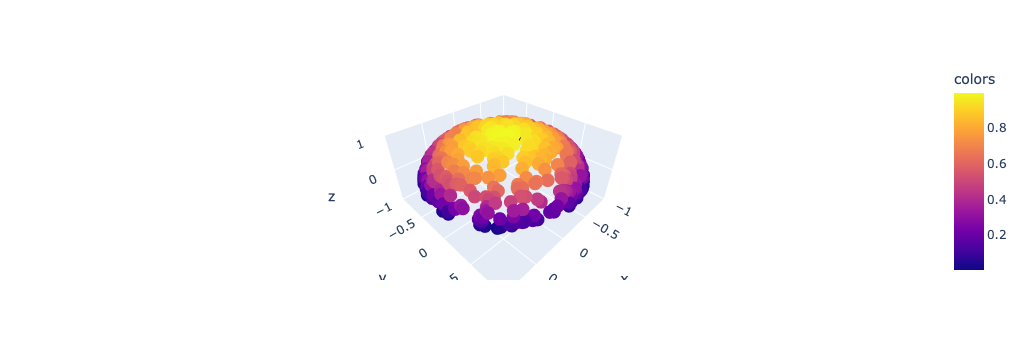

In [51]:
from diffusion_curvature.datasets import sphere
from diffusion_curvature.utils import plot_3d
import matplotlib.pyplot as plt
X_sphere, ks_sphere = sphere(1000) # keep it relatively sparse
X_cap_of_sphere = X_sphere[X_sphere[:,2] > 0] # Just the itty bitty polar top
print('num points',len(X_cap_of_sphere))
plot_3d(X_cap_of_sphere,X_cap_of_sphere[:,2],use_plotly=True)
# plt.scatter(X_cap_of_sphere[:,0],X_cap_of_sphere[:,1])

## With Fractional Diffusion Geodesic AE

In [4]:
MIOFlattener = MIOFlowStandard(
    n_epochs_ode=5000,
    uniformity_loss = "MMD",
    lr=1e-4,
    autoencoder_type = "GAE",
)

Now we'll try doing the whole thing with one function.

In [5]:
# fit transform data
X_cap_of_sphere_flattened = MIOFlattener.fit_transform(X_cap_of_sphere)

Using s_gd2 for MDS. None


AttributeError: 'MIOFlowStandard' object has no attribute 'autoencoder'

In [ ]:
MIOFlattener.visualize_autoencoder(n_samples=250)

<matplotlib.collections.PathCollection>

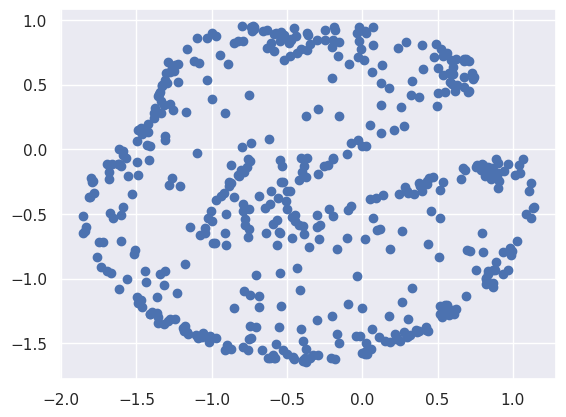

In [ ]:
plt.scatter(X_cap_of_sphere_flattened[:,0],X_cap_of_sphere_flattened[:,1])


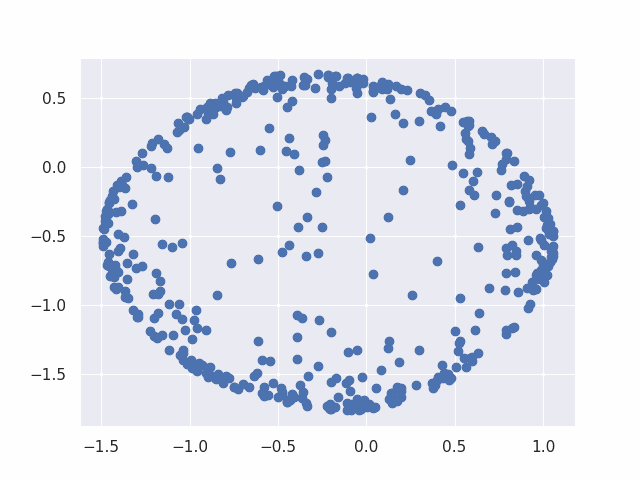

In [ ]:
MIOFlattener.training_gif()

## With Radial Flattening Autoencoder

In [58]:
MIOFlattener = MIOFlowStandard(
    n_epochs_ode=1000,
    uniformity_loss = "MMD",
    lr=1e-4,
    autoencoder_type = "RFAE",
)

Now we'll try doing the whole thing with one function.

In [59]:
# fit transform data
X_cap_of_sphere_flattened = MIOFlattener.fit_transform(X_cap_of_sphere)

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

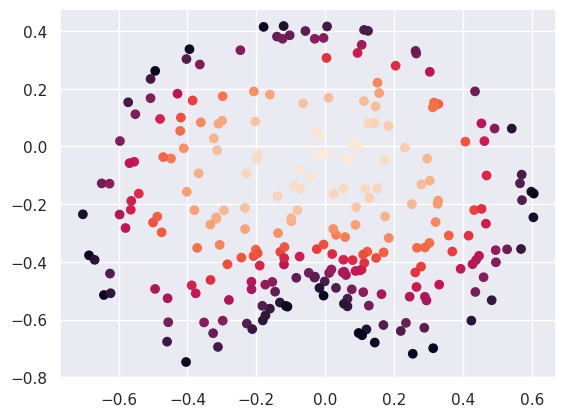

In [60]:
MIOFlattener.visualize_autoencoder(n_samples=250)

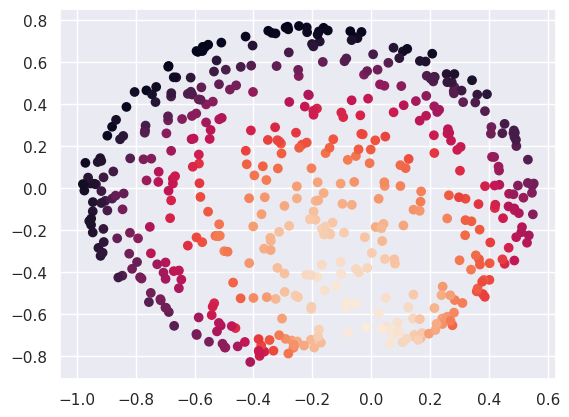

In [61]:
plt.scatter(X_cap_of_sphere_flattened[:,0],X_cap_of_sphere_flattened[:,1], c=X_cap_of_sphere[:,0])


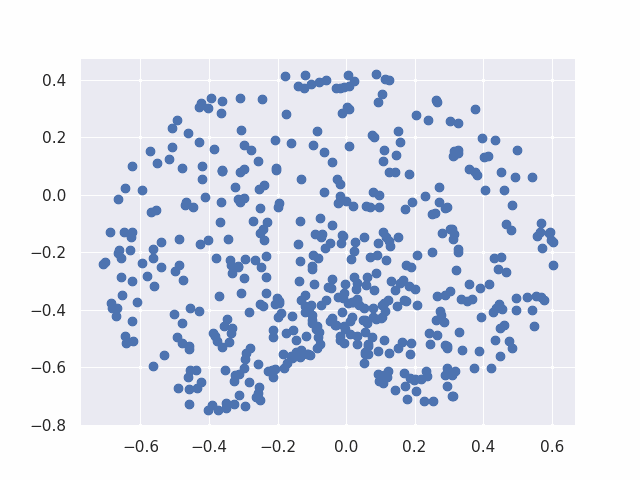

In [62]:
MIOFlattener.training_gif()

In [64]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_gener

<IPython.core.display.Javascript object>

✨ Pixi task (default): nbdev_export
⠁ activating environment                                                        